In [26]:
import pandas as pd
from ta.utils import dropna
import ta.trend as ta_trend
import ta.momentum as ta_mmt
import ta.others as ta_other
import ta 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [27]:
ab_path = "../data/SPY-Daily-Y09-Now_PredictionData.csv"

start_date='2023-01-01'
end_date='2023-12-31'

date_col='Date'
prediction_col='EMA1'
#feature_cols=['SIGNAL']
feature_cols=['EMA1']

In [28]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)


df['EMA1']=ta_trend.ema_indicator(close=df['close'],window=10,fillna=True).round(4)
df['SIGNAL']=ta_trend.macd_signal(close=df['close'], window_slow=20, window_fast=10,window_sign=15, fillna=True).round(4)

allCols=list(df.columns)
print(allCols)


df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

df.info()
df.tail(10)

['Date', 'close', 'EMA1', 'SIGNAL']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2023-01-03 to 2023-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    95 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2023-01-03 to 2023-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    95 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


,EMA1
Date,
2023-05-05,410.4521
2023-05-08,410.8681
2023-05-09,410.8793
2023-05-10,411.2376
2023-05-11,411.3999
2023-05-12,411.4344
2023-05-15,411.7209
2023-05-16,411.4535
2023-05-17,412.1401


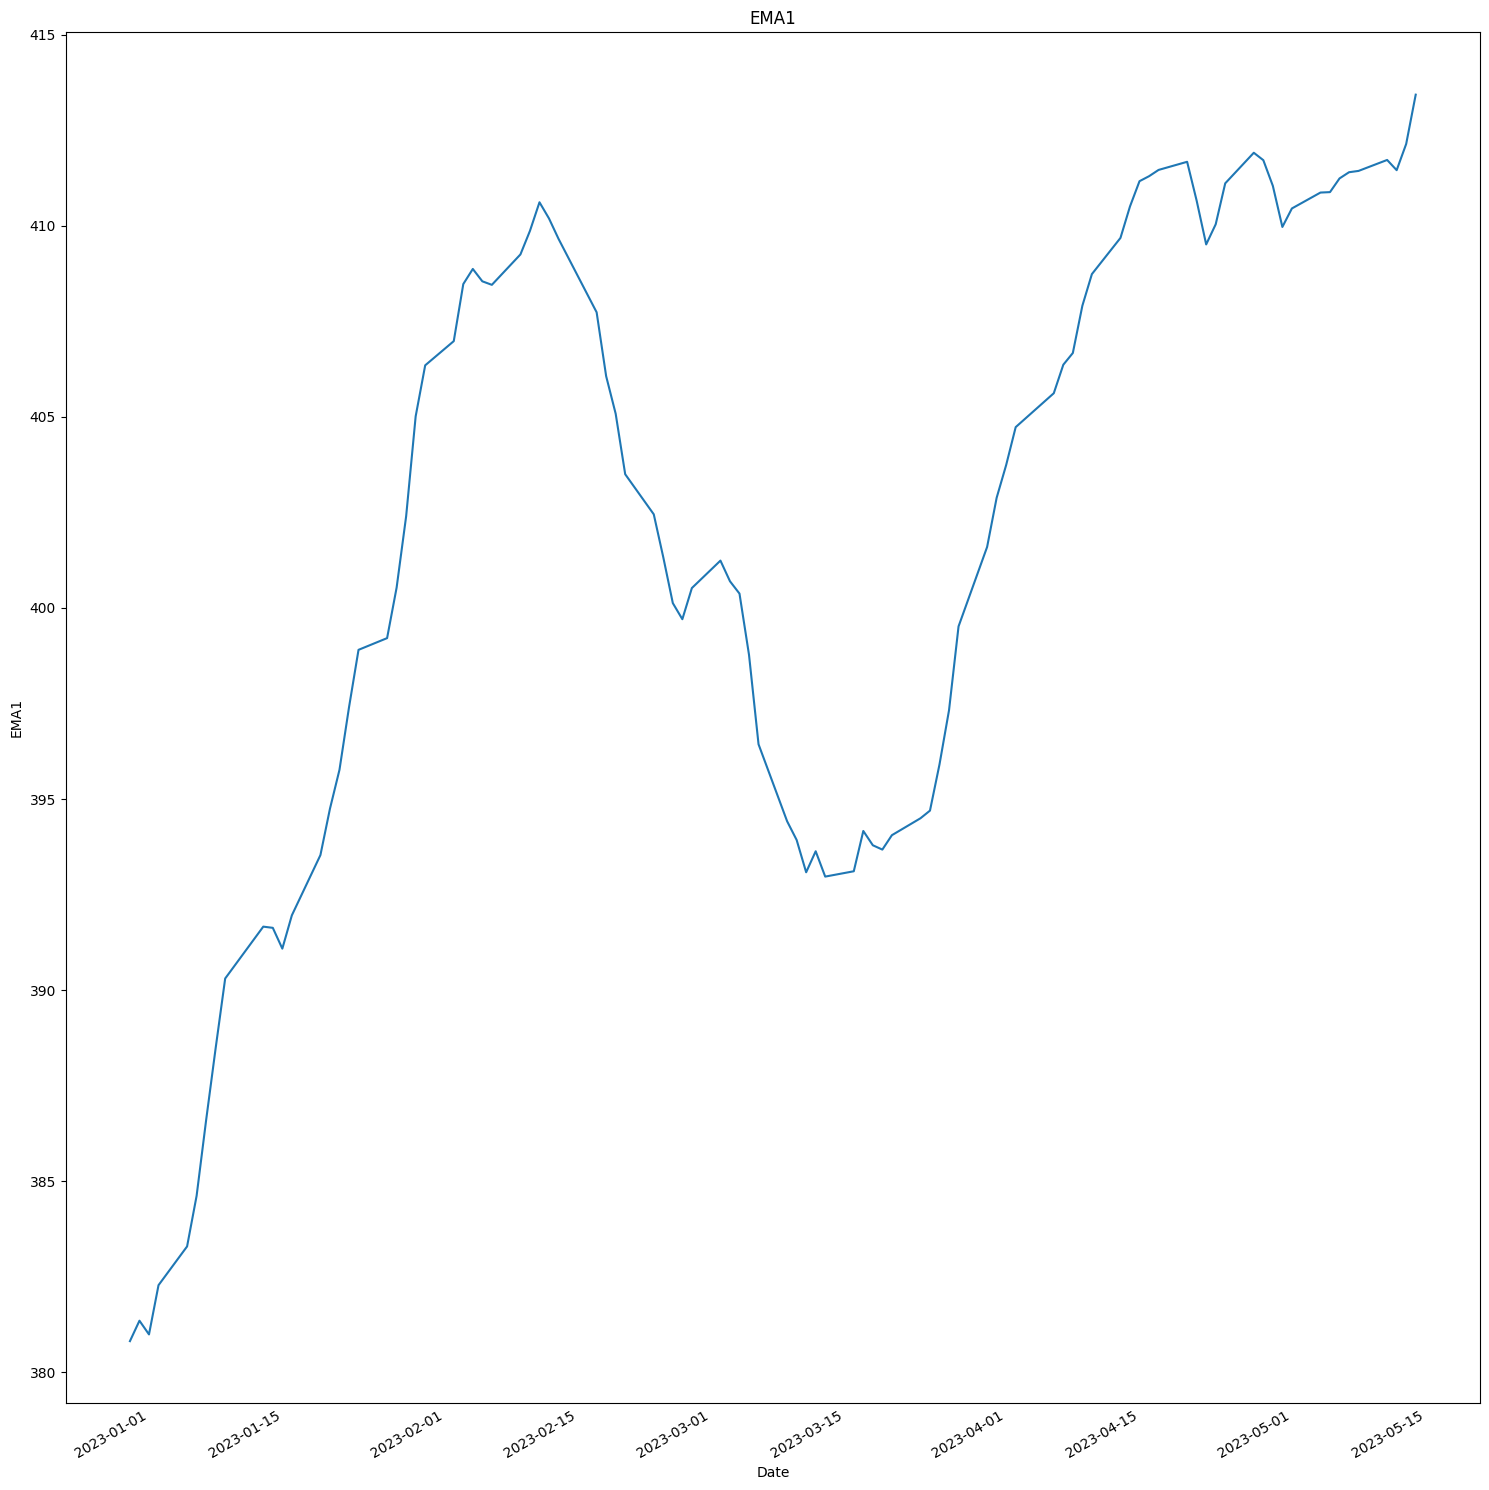

In [29]:
ncols = 1
nrows = len(feature_cols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()